# Melanoma Detection

## Importing Libraries

In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/ed/b6/62345568cd07de5d9254fcf64d7e44aacbb6abde11ea953b3cb320e58d19/tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
Using cached tensorflow-2.17.0-cp311-cp311-win_amd64.whl (2.0 kB)
Note: you may need to restart the kernel to use updated packages.


In [31]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, Conv2D, MaxPool2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Rescaling)

## Importing Dataset

In [2]:
data_dir_train = pathlib.Path(r"C:\Users\Skyline Solutions\Desktop\Melanoma Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test")
data_dir_test = pathlib.Path(r'C:\Users\Skyline Solutions\Desktop\Melanoma Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train')

In [3]:
# to count total no of images in dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

94
2239


## Defining Dataset 

In [4]:
# Define some batch size, height and width of image to load
batch_size = 32
img_height = 180
img_width = 180

Image loading by using keras.preprocessing

Image to be loaded off from dataset by image_dataset_from_directory utility.

Splitting 80% of the data for training the model and 20% for validation segment.

In [5]:
# segmenting train and validation set from dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 94 files belonging to 8 classes.
Using 76 files for training.


In [6]:
# Segregation of validation set from dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 94 files belonging to 8 classes.
Using 18 files for validation.


In [7]:
# Classifying all type of skin cancer
Name_of_class = train_dataset.class_names
print(Name_of_class)

['basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
# Coutning no's of images in each class type of Train datset
for i in Name_of_class:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

basal cell carcinoma :  8
dermatofibroma :  16
melanoma :  16
nevus :  16
pigmented benign keratosis :  16
seborrheic keratosis :  3
squamous cell carcinoma :  16
vascular lesion :  3


In [9]:
# Coutning no's of images in each class type of Test datset
for i in Name_of_class:
  print(i,": ",len(list(data_dir_test.glob('{}/*.jpg'.format(i)))))

basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


## Data Visualization 

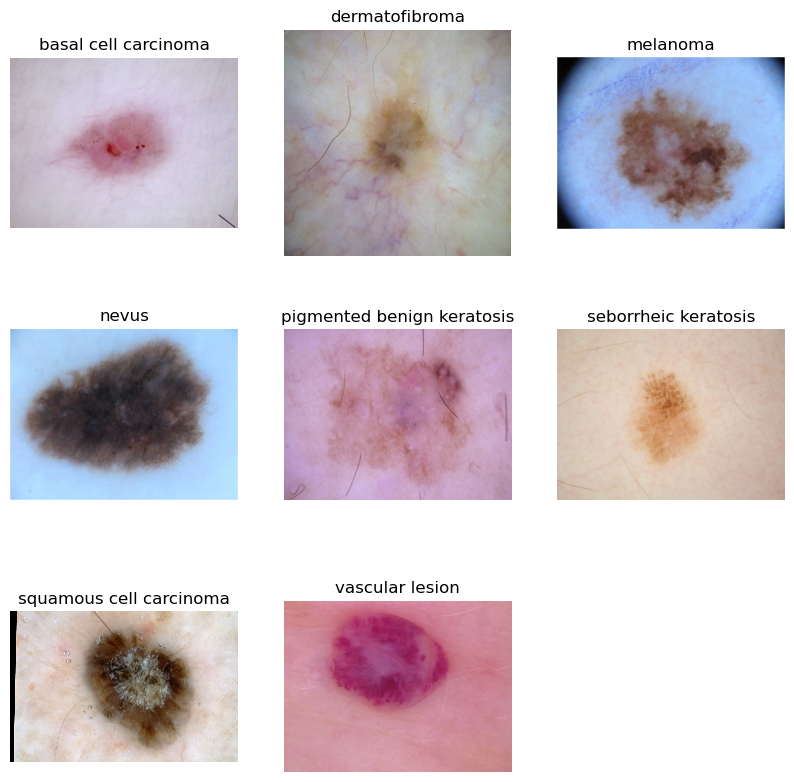

In [10]:
# Having random view of each type of Images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for index,images in enumerate(Name_of_class):

  temp=plt.imread(list(data_dir_train.glob('{}/*.jpg'.format(images)))[0])

  plt.subplot(3,3,index+1)
  plt.imshow(temp)
  plt.axis('off')
  plt.title(images)

In [11]:
# to confirm shape and size of Image
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


A tensor of the size (32, 180, 180, 3) is dimension of one image batch. Here it is group of 32 images with dimension 180x180x3 (the last one is for color channels RGB).

In [12]:
#Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.
#Dataset.prefetch() overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset= validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Standardization of images

The RGB channel values ranges in between 0 to 225, which is not good in case of neural network. Ideally it should be in between 0 and 1.

In [14]:
normalised_layer = tf.keras.layers.Rescaling(1./255)
normalized_dataset = train_dataset.map(lambda x, y: (normalised_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))

## Creating and training Model 

### Model 1

Creating First model to identify total 9 classes in dataset.

In [15]:
# Define image dimensions
img_height = 180
img_width = 180

# Initialize the model
model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Corrected input_shape here
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

C:\Users\Skyline Solutions\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compilation of Model

In [16]:
# Using adam as optimiser and loss function to train the Model
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
# Checking summery of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Training the Model after optimising with 20 epochs
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.1914 - loss: 2.3120 - val_accuracy: 0.2222 - val_loss: 2.5350
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.2407 - loss: 2.1790 - val_accuracy: 0.2222 - val_loss: 2.0804
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.2509 - loss: 1.9524 - val_accuracy: 0.2222 - val_loss: 1.9040
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.3639 - loss: 1.8700 - val_accuracy: 0.1111 - val_loss: 1.8939
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.3832 - loss: 1.7004 - val_accuracy: 0.5000 - val_loss: 1.8276
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.4906 - loss: 1.5165 - val_accuracy: 0.2222 - val_loss: 1.7929
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.3796 - loss: 1.4819 - val_accuracy: 0.3333 - val_loss: 1.5965
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.5263 - loss: 1.3960 - val_accuracy: 0.3333 - val_loss:

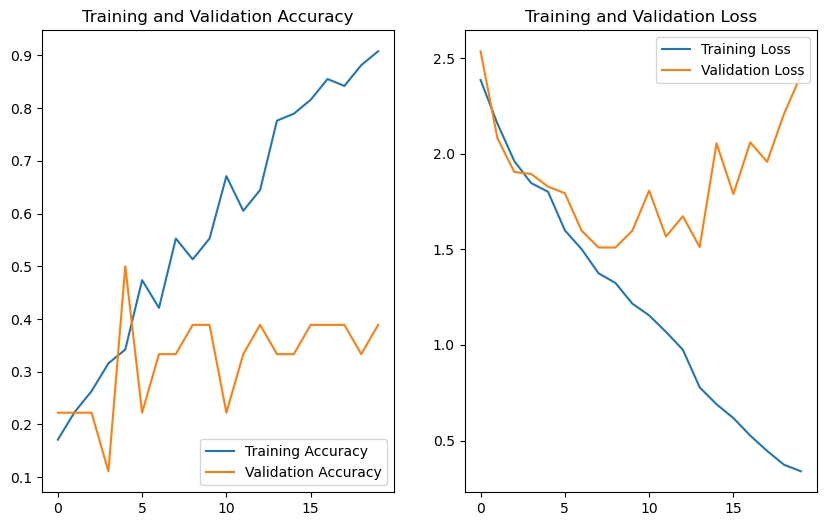

In [20]:
# Checking results of Model 1
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings: 

In [24]:
loss, accuracy = model.evaluate(train_dataset, verbose=1,)
loss_v, accuracy_v = model.evaluate(validation_dataset, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9607 - loss: 0.2408
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3889 - loss: 2.4082
Accuracy:  0.9605262875556946
Validation Accuracy:  0.3888888955116272
Loss:  0.23297613859176636
Validation Loss 2.4082229137420654


Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.


In [25]:
data_augument = keras.Sequential([
                             layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.RandomRotation(0.2, fill_mode='reflect'),
                             layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

Todo, visualize how your augmentation strategy works for one instance of training image.

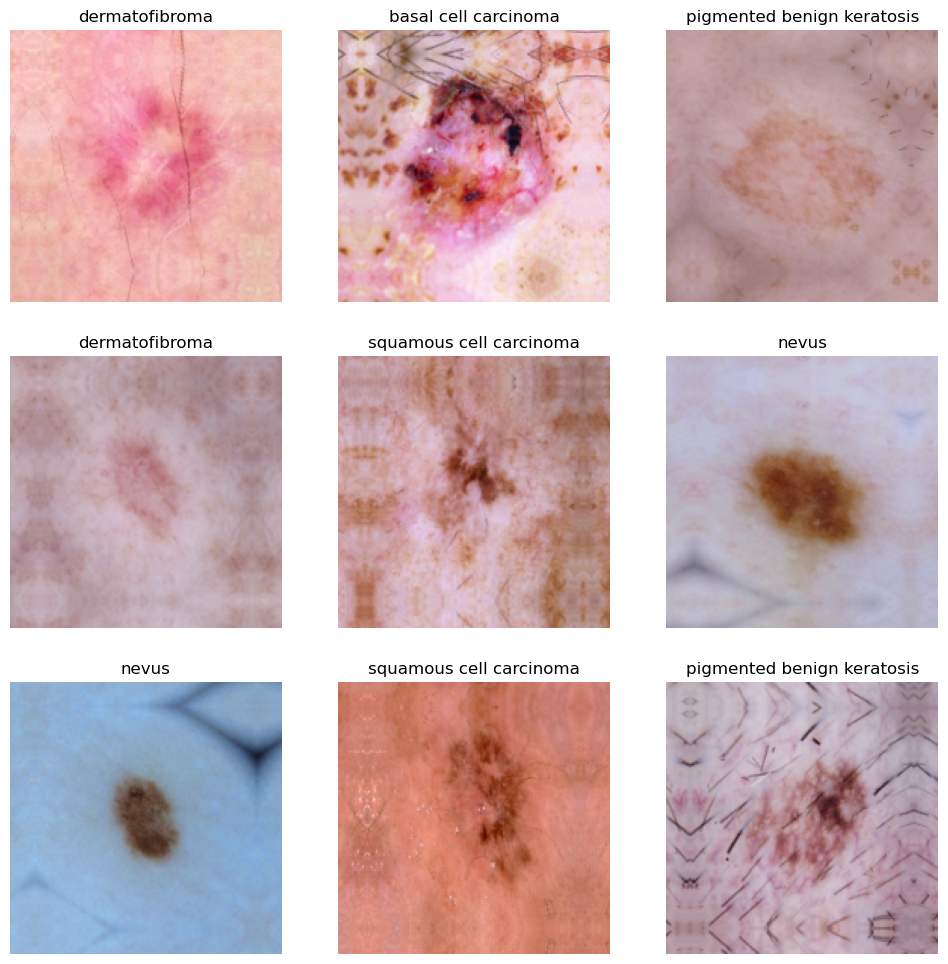

In [28]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(Name_of_class[labels[i]])
        plt.axis("off")

### Model 2 

Create the model 2, compile and train the model

In [32]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


In [33]:
#compiling model 2
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
#training model for 30 epochs
epochs=30
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/30


C:\Users\Skyline Solutions\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1578 - loss: 2.1471 - val_accuracy: 0.2222 - val_loss: 1.9720
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1885 - loss: 2.0650 - val_accuracy: 0.2222 - val_loss: 2.0120
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2233 - loss: 1.9338 - val_accuracy: 0.2222 - val_loss: 2.1744
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3244 - loss: 1.9804 - val_accuracy: 0.3889 - val_loss: 1.8904
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2925 - loss: 1.7316 - val_accuracy: 0.3333 - val_loss: 1.7123
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3861 - loss: 1.5546 - val_accuracy: 0.1111 - val_loss: 2.3498
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3039 - loss: 2.0506 - val_accuracy: 0.1667 - val_loss: 2.3970
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2553 - loss: 1.8451 - val_accuracy: 0.1667 - val_loss: 1.7481
Epoch 9/30
3/3 ━━━━━━━━━━━━

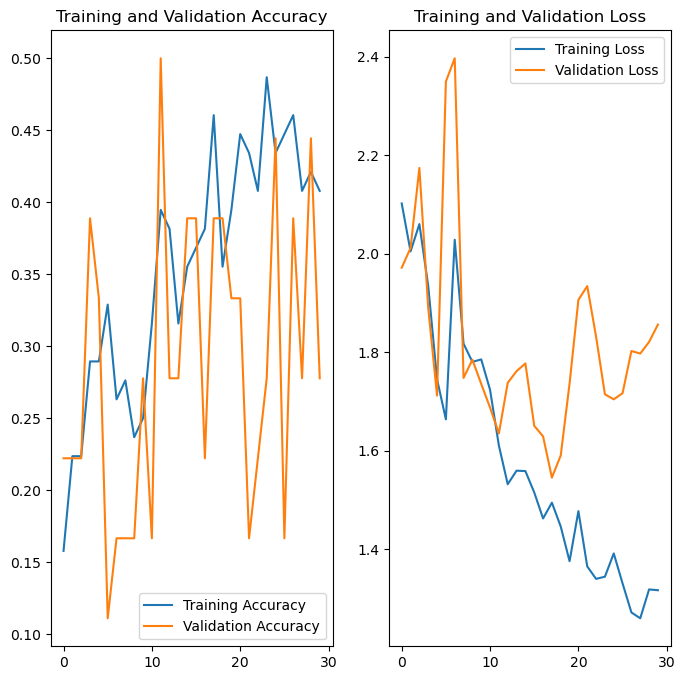

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
loss, accuracy = model.evaluate(train_dataset, verbose=1,)
loss_v, accuracy_v = model.evaluate(validation_dataset, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step - accuracy: 0.4725 - loss: 1.2921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.2778 - loss: 1.8565
Accuracy:  0.46052631735801697
Validation Accuracy:  0.2777777910232544
Loss:  1.2776814699172974
Validation Loss 1.856518268585205


Still the accuracy is low , even though the deviation of training and validation result has reduced. Lets try another strategy.

In [40]:
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

# Create training images generator
image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

# Create training images generator
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=data_dir_train,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=data_dir_test,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 94 images belonging to 8 classes.
Found 2239 images belonging to 9 classes.


In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Model 3 

In [41]:
model = Sequential()


model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=20
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.1702 - loss: 4.0445 - val_accuracy: 0.1728 - val_loss: 8.1495
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.2447 - loss: 5.5849 - val_accuracy: 0.0424 - val_loss: 6.8906
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.1809 - loss: 4.7341 - val_accuracy: 0.1858 - val_loss: 4.0945
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.2021 - loss: 2.8851 - val_accuracy: 0.0509 - val_loss: 2.9867
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.2234 - loss: 2.1294 - val_accuracy: 0.0469 - val_loss: 2.5705
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.2447 - loss: 1.9166 - val_accuracy: 0.0335 - val_loss: 2.4433
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.2979 - loss: 1.8623 - val_accuracy: 0.0344 - val_loss: 2.4639
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.3191 - loss: 1.7914 - val_accuracy: 0.0295 - val_loss: 2.5589


### Visualizing the result 

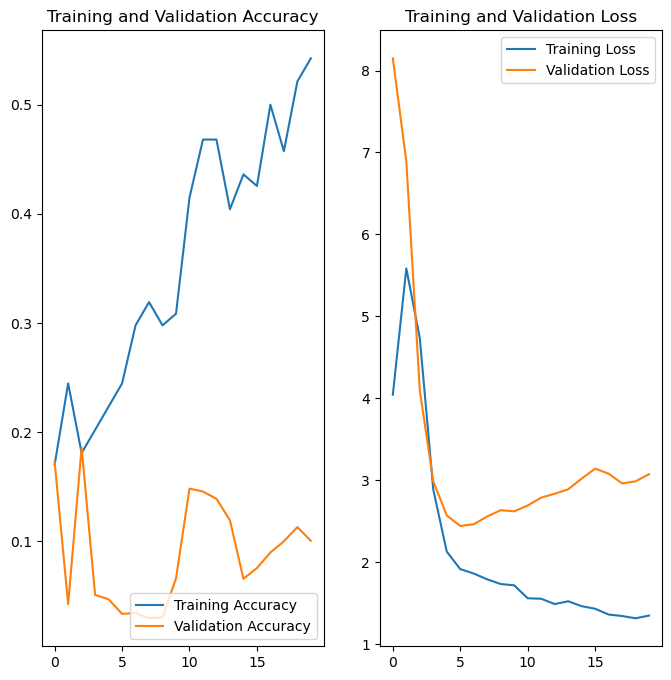

In [44]:
epochs = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?¶
Still the model's accuracy is not as expected, there is an issue of class imbalance which needs to be addressed.

Todo: Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data

In [45]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

94

In [46]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
1,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
2,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
3,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
4,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
...,...,...
89,C:\Users\Skyline Solutions\Desktop\Melanoma De...,squamous cell carcinoma
90,C:\Users\Skyline Solutions\Desktop\Melanoma De...,squamous cell carcinoma
91,C:\Users\Skyline Solutions\Desktop\Melanoma De...,vascular lesion
92,C:\Users\Skyline Solutions\Desktop\Melanoma De...,vascular lesion


Class=0, n=8 (8.511%)
Class=1, n=16 (17.021%)
Class=2, n=16 (17.021%)
Class=3, n=16 (17.021%)
Class=4, n=16 (17.021%)
Class=5, n=3 (3.191%)
Class=6, n=16 (17.021%)
Class=7, n=3 (3.191%)


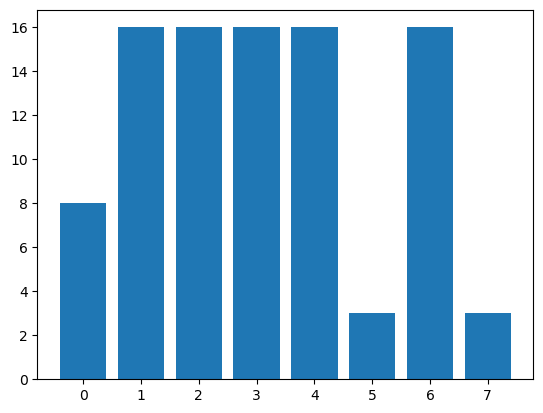

In [47]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [48]:
from sklearn.utils import class_weight

class_weight = {0:5.09,
                1:16.79,
                2:4.24,
                3:19.56,
                4:15.94,
                5:20.63,
                6:3.43,
                7:8.08,
                8:6.20}

num_classes = 9


model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes)

])

C:\Users\Skyline Solutions\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  class_weight=class_weight)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.1041 - loss: 23.3747 - val_accuracy: 0.2222 - val_loss: 2.2046
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.2366 - loss: 19.1500 - val_accuracy: 0.1111 - val_loss: 2.2216
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3330 - loss: 18.1650 - val_accuracy: 0.2778 - val_loss: 1.9483
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.2811 - loss: 16.6420 - val_accuracy: 0.2222 - val_loss: 2.0575
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.3396 - loss: 15.0631 - val_accuracy: 0.3889 - val_loss: 2.0609
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3413 - loss: 16.1173 - val_accuracy: 0.4444 - val_loss: 1.9040
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3744 - loss: 14.8681 - val_accuracy: 0.2778 - val_loss: 1.9934
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3522 - loss: 14.6768 - val_accuracy: 0.5000 - v

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples

In [52]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for Augmentor from https://files.pythonhosted.org/packages/f3/86/5a91176650eb229ea2cd95551c34c36fba6cd95da3bdc4a5c73fbb1536ca/Augmentor-0.2.12-py2.py3-none-any.whl.metadata


In [54]:
path_to_training_dataset=str(data_dir_train)

#print(path_to_training_dataset)
import Augmentor
for i in Name_of_class:
    folder_name = path_to_training_dataset +"/" + i
    #print(folder_name)
    p = Augmentor.Pipeline(folder_name)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 8 image(s) found.
Output directory set to C:\Users\Skyline Solutions\Desktop\Melanoma Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x179CB3EEA10>: 100%|██████████| 500/500 [00:04<00:00, 122.68 Samples/s]                  


Initialised with 16 image(s) found.
Output directory set to C:\Users\Skyline Solutions\Desktop\Melanoma Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x179CBAE1ED0>: 100%|██████████| 500/500 [02:13<00:00,  3.75 Samples/s]                    


Initialised with 16 image(s) found.
Output directory set to C:\Users\Skyline Solutions\Desktop\Melanoma Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x179CBB0D390>: 100%|██████████| 500/500 [00:17<00:00, 28.60 Samples/s]


Initialised with 16 image(s) found.
Output directory set to C:\Users\Skyline Solutions\Desktop\Melanoma Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1022x767 at 0x179CB4F0B50>: 100%|██████████| 500/500 [00:10<00:00, 47.96 Samples/s] 


Initialised with 16 image(s) found.
Output directory set to C:\Users\Skyline Solutions\Desktop\Melanoma Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17ACF86BDD0>: 100%|██████████| 500/500 [00:04<00:00, 124.07 Samples/s]                  


Initialised with 3 image(s) found.
Output directory set to C:\Users\Skyline Solutions\Desktop\Melanoma Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x179CB4E3790>: 100%|██████████| 500/500 [00:09<00:00, 50.92 Samples/s]                  


Initialised with 16 image(s) found.
Output directory set to C:\Users\Skyline Solutions\Desktop\Melanoma Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x179CBB0EC10>: 100%|██████████| 500/500 [02:07<00:00,  3.92 Samples/s]                    


Initialised with 3 image(s) found.
Output directory set to C:\Users\Skyline Solutions\Desktop\Melanoma Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17ACF868F90>: 100%|██████████| 500/500 [00:04<00:00, 118.65 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [55]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4000


Lets see the distribution of augmented data after adding new images to the original training data.

In [56]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [57]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [58]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [59]:
original_df

,Path,Label
0,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
1,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
2,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
3,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
4,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
...,...,...
89,C:\Users\Skyline Solutions\Desktop\Melanoma De...,squamous cell carcinoma
90,C:\Users\Skyline Solutions\Desktop\Melanoma De...,squamous cell carcinoma
91,C:\Users\Skyline Solutions\Desktop\Melanoma De...,vascular lesion
92,C:\Users\Skyline Solutions\Desktop\Melanoma De...,vascular lesion


In [60]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
1,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
2,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
3,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
4,C:\Users\Skyline Solutions\Desktop\Melanoma De...,basal cell carcinoma
...,...,...
3995,C:\Users\Skyline Solutions\Desktop\Melanoma De...,vascular lesion
3996,C:\Users\Skyline Solutions\Desktop\Melanoma De...,vascular lesion
3997,C:\Users\Skyline Solutions\Desktop\Melanoma De...,vascular lesion
3998,C:\Users\Skyline Solutions\Desktop\Melanoma De...,vascular lesion


In [61]:
new_df = pd.concat([original_df, df2], ignore_index=True)

In [62]:
new_df['Label'].value_counts()

Label
dermatofibroma                516
melanoma                      516
nevus                         516
pigmented benign keratosis    516
squamous cell carcinoma       516
basal cell carcinoma          508
seborrheic keratosis          503
vascular lesion               503
Name: count, dtype: int64

Todo: Train the model on the data created using Augmentor

In [63]:
batch_size = 32
img_height = 180
img_width = 180

Todo: Create a training dataset

In [64]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4094 files belonging to 8 classes.
Using 3276 files for training.


Todo: Create your model (make sure to include normalization)

In [68]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Todo: Compile your model (Choose optimizer and loss function appropriately)

In [69]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.1544 - loss: 2.5467 - val_accuracy: 0.2222 - val_loss: 2.5135
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.1700 - loss: 2.2003 - val_accuracy: 0.2222 - val_loss: 1.9669
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.2555 - loss: 1.8747 - val_accuracy: 0.2222 - val_loss: 1.9155
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.3001 - loss: 1.7978 - val_accuracy: 0.2778 - val_loss: 1.8197
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.4510 - loss: 1.6608 - val_accuracy: 0.2778 - val_loss: 1.7835
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.4568 - loss: 1.6318 - val_accuracy: 0.4444 - val_loss: 1.6588
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.5607 - loss: 1.4368 - val_accuracy: 0.4444 - val_loss: 1.5716
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.5795 - loss: 1.2995 - val_accuracy: 0.3889 - val_loss:

Todo: Visualize the model results

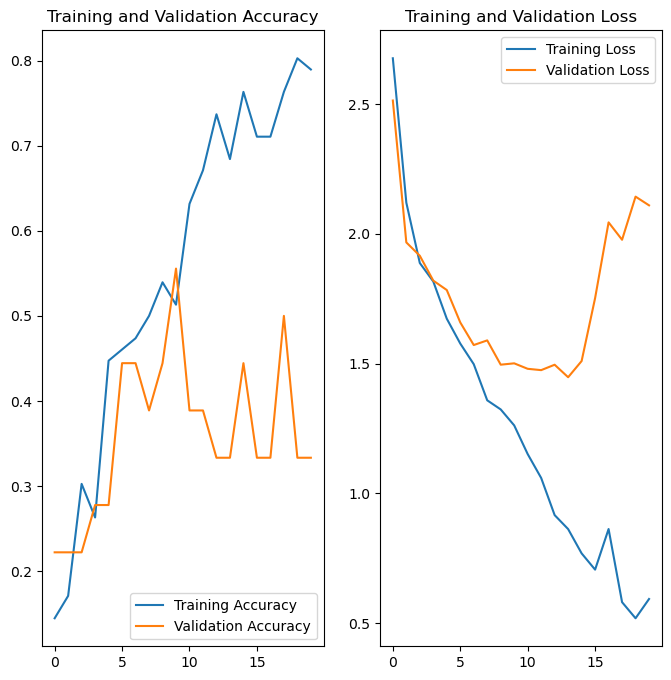

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

In [72]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9319 - loss: 0.3440
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3333 - loss: 2.1097
Accuracy:  0.9342105388641357
Validation Accuracy:  0.3333333432674408
Loss:  0.3233143985271454
Validation Loss 2.109748125076294


Now that the issue of class imbalance has been addressed, we can see that accuracy of training and validation data is much better, indicating the model has fitted well.